In [334]:
import pandas as pd
import mysql.connector
from scipy.stats import ttest_rel
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.scale import LogScale

sns.set_style("darkgrid")
sns.set_theme("notebook")

# I. Connecter le notebook à MySQL

In [335]:
conn = mysql.connector.connect(
        host='localhost',
        user='root',
        password='087430',
        database='Statistiques')

curs = conn.cursor()

def query_to_dataframe(query):
    curs.execute(query)
    columns = [desc[0] for desc in curs.description]
    rows = curs.fetchall()
    return pd.DataFrame(rows, columns=columns)

## 1.Bis Vérification des tendances de croissance de la population entre le début et la fin des intervales de temps

In [336]:
res = query_to_dataframe(
"""SELECT populationDebut, populationFin
FROM Statistiques
""")

t, p = ttest_rel(res['populationDebut'], res['populationFin'], alternative='less')
print(p)

2.5670138801853213e-240


Nous pouvons TRèS confiamment affirmer que les population de début des tranches d'années sont significativement plus petites que les populations de fin.

De ce fait, lorsque nous chercherons des statistiques maximales, il conviendra de les chercher auprès des anneeSup, et les minimales auprès de anneeInf

# II. Requêtes

## 1. Liste des populations en 2020 avec le nom de ville, département, région

In [337]:
res = query_to_dataframe(
"""
SELECT 
    c.nomCommune,
    d.nomDepartement,
    r.nomRegion,
    s.populationFin AS population_2020
FROM Regions r
JOIN Departements d ON r.codeRegion = d.codeRegion
JOIN Communes c ON d.codeDepartement = c.codeDepartement
JOIN Statistiques s ON c.codeCommune = s.codeCommune
WHERE s.anneeSup = 2020;
""")

res.head()

,nomCommune,nomDepartement,nomRegion,population_2020
0,Les Abymes,Guadeloupe,Guadeloupe,52948
1,Anse-Bertrand,Guadeloupe,Guadeloupe,3871
2,Baie-Mahault,Guadeloupe,Guadeloupe,30316
3,Baillif,Guadeloupe,Guadeloupe,5122
4,Basse-Terre,Guadeloupe,Guadeloupe,9892


## 2. Évolution de la population française de 1968 à 2020.

In [338]:
res = query_to_dataframe(
"""
WITH s1968 AS (
    SELECT SUM(s.populationDebut) AS population
    FROM Statistiques s
    WHERE s.anneeInf = 1968),
s2020 AS (
    SELECT SUM(s.populationFin) AS population
    FROM Statistiques s
    WHERE s.anneeSup = 2020)
SELECT 
    s1968.population AS `1968`,
    s2020.population AS `2020`,
    (s2020.population - s1968.population) AS difference
FROM s1968, s2020;
""")

res.head()

,1968,2020,difference
0,54805712,70700609,15894897


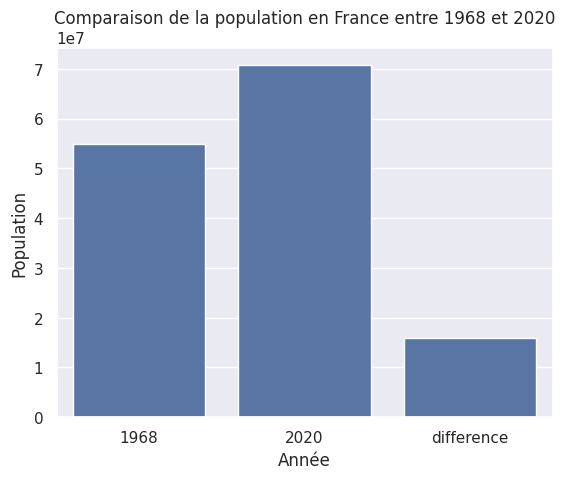

In [339]:
res = pd.melt(res, var_name="Année", value_name="Population")
sns.barplot(data=res, x="Année", y="Population")
plt.title("Comparaison de la population en France entre 1968 et 2020")
plt.show()

## 3. Liste des populations en 2020 par département / région avec leurs noms (2 requêtes).

### A. Par département

In [340]:
res = query_to_dataframe(
"""
SELECT 
    d.nomDepartement AS Departement,
    SUM(s.populationFin) AS Population
FROM Departements d
JOIN Communes c ON d.codeDepartement = c.codeDepartement
JOIN Statistiques s ON c.codeCommune = s.codeCommune
WHERE s.anneeSup = 2020
GROUP BY d.nomDepartement
ORDER BY Population DESC;
""")

res.head()

,Departement,Population
0,Paris,4291812
1,Bouches-du-Rhône,2918391
2,Nord,2607746
3,Rhône,2405665
4,Seine-Saint-Denis,1655422


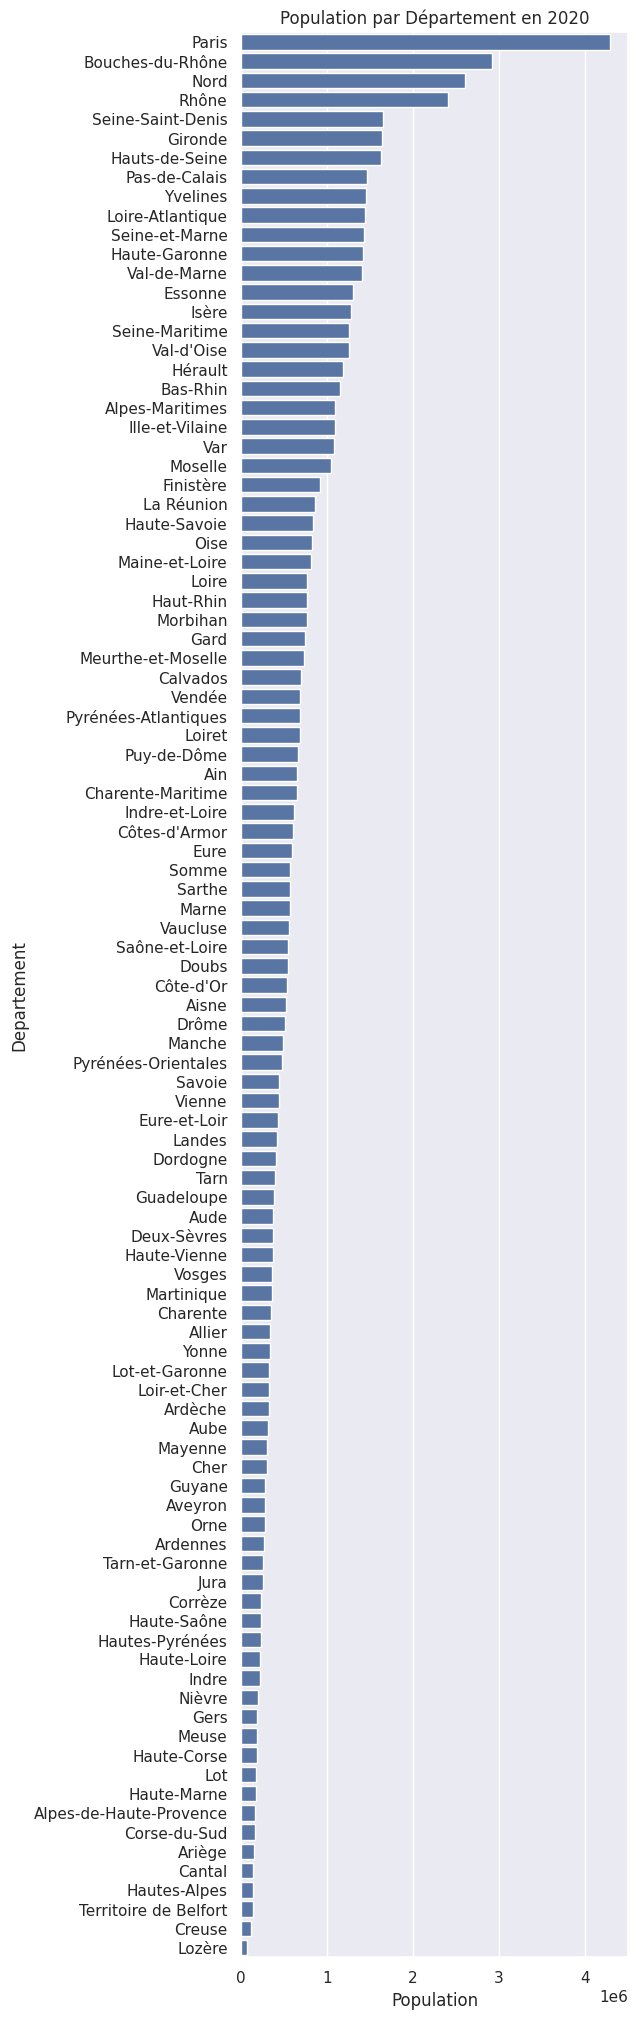

In [341]:
plt.figure(figsize=(5, 25))
sns.barplot(data=res, y="Departement", x="Population")
plt.title("Population par Département en 2020")
plt.show()

### B. Par Région

In [342]:
res = query_to_dataframe(
"""
SELECT 
    r.nomRegion as Region,
    SUM(s.populationFin) AS Population
FROM Regions r
JOIN Departements d ON r.codeRegion = d.codeRegion
JOIN Communes c ON d.codeDepartement = c.codeDepartement
JOIN Statistiques s ON c.codeCommune = s.codeCommune
WHERE s.anneeSup = 2020
GROUP BY r.nomRegion
ORDER BY Population DESC;
""")

res.head()

,Region,Population
0,Île-de-France,14417700
1,Auvergne-Rhône-Alpes,8600880
2,Nouvelle-Aquitaine,6033952
3,Hauts-de-France,5997734
4,Occitanie,5973969


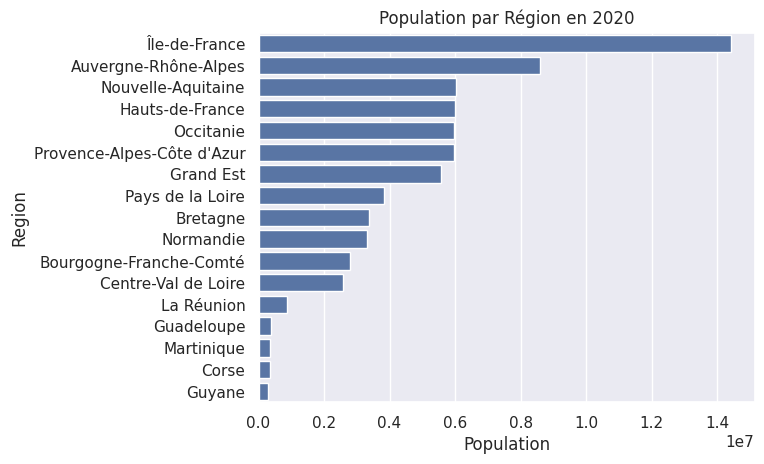

In [343]:
sns.barplot(data=res, y="Region", x="Population")
plt.title("Population par Région en 2020")
plt.show()

## 4. Population de Paris au total et par arrondissement. Quel est le problème ? Corriger et vérifier que ce cas n’est pas produit ailleurs. Revoir la question 2.

### A. Identification du problème relatif à Paris

In [344]:
res = query_to_dataframe(
"""
SELECT 
    c.nomCommune, 
    s.populationFin AS population
FROM Communes c 
JOIN Statistiques s ON c.codeCommune = s.codeCommune
WHERE c.nomCommune LIKE 'Paris%'
  AND s.anneeSup = 2020;
""")

res

,nomCommune,population
0,Paris-l'Hôpital,308
1,Paris,2145906
2,Paris 1er Arrondissement,16030
3,Paris 2e Arrondissement,21130
4,Paris 3e Arrondissement,33402
5,Paris 4e Arrondissement,29064
6,Paris 5e Arrondissement,57380
7,Paris 6e Arrondissement,39625
8,Paris 7e Arrondissement,48520
9,Paris 8e Arrondissement,35631


Plusieurs communes contiennent "Paris", dont une représentant la ville de Paris, et 20 autres représentant les arrondissements de la ville de Paris.

Si la somme des statistiques des arrondissements de Paris sont égaux aux statistiques de la ville de Paris, alors nous pouvons suspecter que Paris compte déjà les statistiques de ses arrondissement.

In [345]:
res = query_to_dataframe(
"""WITH ParisArrondissement2020 AS (
    SELECT SUM(s.populationFin) AS population_parisArrondissement
    FROM Communes c 
    JOIN Statistiques s ON c.codeCommune = s.codeCommune
    WHERE c.nomCommune LIKE 'Paris % Arrondissement'
      AND s.anneeSup = 2020),
ParisVille2020 AS (
    SELECT s.populationFin AS population_paris
    FROM Communes c 
    JOIN Statistiques s ON c.codeCommune = s.codeCommune
    WHERE c.nomCommune = 'Paris'
      AND s.anneeSup = 2020)
SELECT 
    population_paris,
    population_parisArrondissement
FROM ParisVille2020, ParisArrondissement2020;""")

res

,population_paris,population_parisArrondissement
0,2145906,2145906


Les statistiques de la population correspondent, nous considérons désomais que Paris contient déjà les statistiques de communes de la forme "Paris Ne Arrondissement", il faut les exclure dans les requêtes où il s'agit de sommer les statistiques des communes.

### B. Recherche d'autres villes sujettes à ce problème

In [346]:
res = query_to_dataframe(
"""SELECT nomCommune AS Commune
FROM Communes
WHERE nomCommune LIKE "%Arrondissement%";""")

res["Commune"] = res["Commune"].str[:-18]
res["Commune"].unique()

array(['Marseille ', 'Marseille', 'Lyon ', 'Lyon', 'Paris ', 'Paris'],
      dtype=object)

Le problème touche aussi les villes de Marseille et Lyon.

### C. Correction des questions précédentes en tenant compte de ce problème

#### 2.1 Évolution de la population française de 1968 à 2020

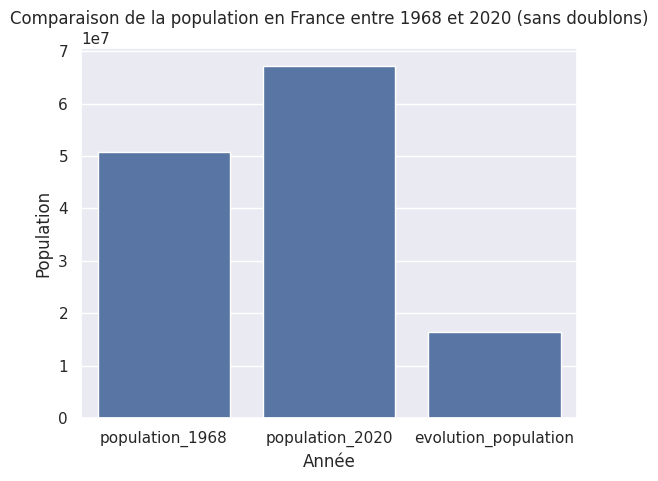

In [347]:
res = query_to_dataframe(
"""WITH s1968 AS (
    SELECT SUM(s.populationDebut) AS population
    FROM Statistiques s
    JOIN Communes c ON c.codeCommune = s.codeCommune
    WHERE s.anneeInf = 1968
		AND c.nomCommune NOT LIKE "%Arrondissement%"),
s2020 AS (
    SELECT SUM(s.populationFin) AS population
    FROM Statistiques s
    JOIN Communes c ON c.codeCommune = s.codeCommune
    WHERE s.anneeSup = 2020
		AND c.nomCommune NOT LIKE "%Arrondissement%")
SELECT 
    s1968.population AS population_1968,
    s2020.population AS population_2020,
    (s2020.population - s1968.population) AS evolution_population
FROM s1968, s2020;
""")

res = pd.melt(res, var_name="Année", value_name="Population")
sns.barplot(data=res, x="Année", y="Population")
plt.title("Comparaison de la population en France entre 1968 et 2020 (sans doublons)")
plt.show()


#### 3.1 Liste des populations en 2020 par département / région avec leurs noms (2 requêtes).

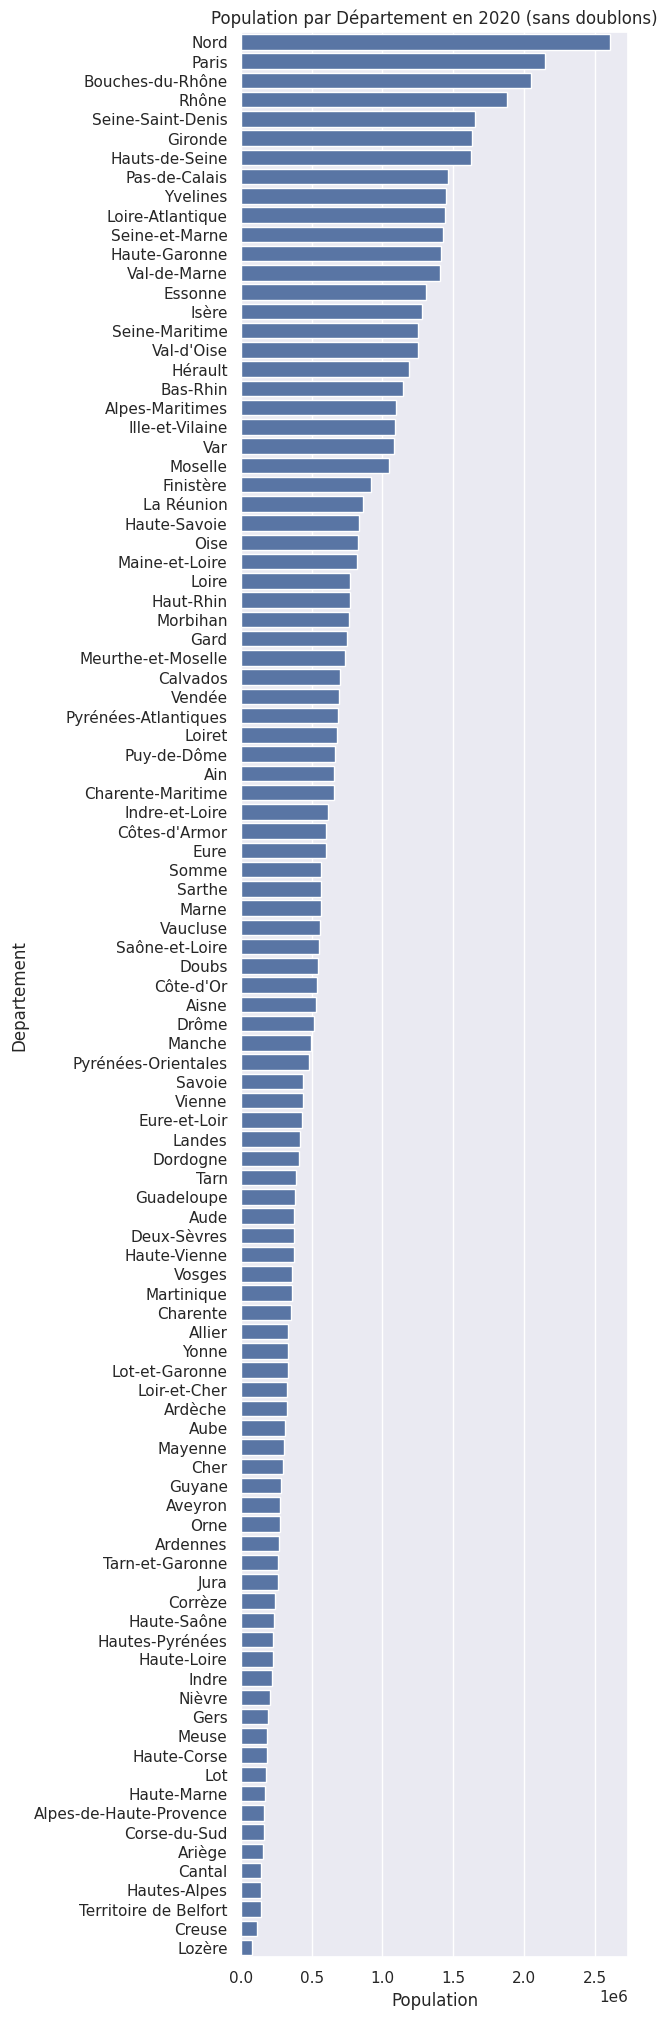

In [348]:
res = query_to_dataframe(
"""SELECT 
    d.nomDepartement AS Departement,
    SUM(s.populationFin) AS Population
FROM Departements d
JOIN Communes c ON d.codeDepartement = c.codeDepartement
JOIN Statistiques s ON c.codeCommune = s.codeCommune
WHERE s.anneeSup = 2020
	AND c.nomCommune NOT LIKE "%Arrondissement%"
GROUP BY d.nomDepartement
ORDER BY Population DESC;
"""
)

plt.figure(figsize=(5, 25))
sns.barplot(data=res, y="Departement", x="Population")
plt.title("Population par Département en 2020 (sans doublons)")
plt.show()


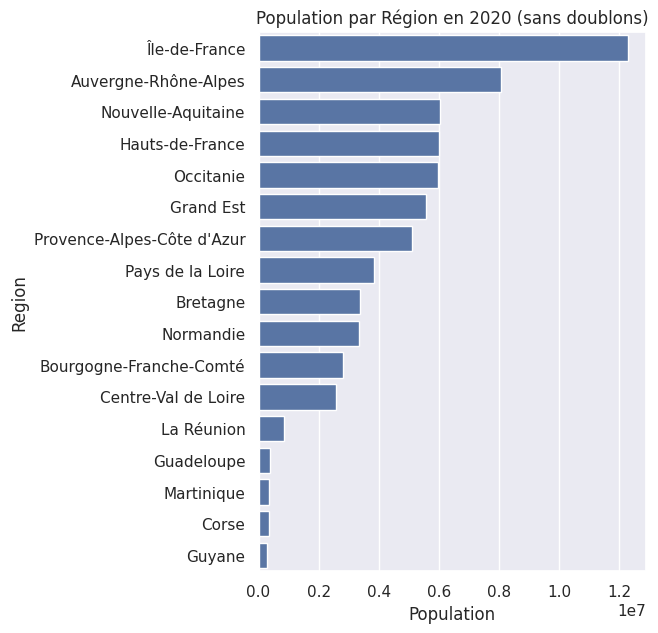

In [349]:
res = query_to_dataframe(
"""SELECT 
    r.nomRegion AS Region,
    SUM(s.populationFin) AS Population
FROM Regions r
JOIN Departements d ON r.codeRegion = d.codeRegion
JOIN Communes c ON d.codeDepartement = c.codeDepartement
JOIN Statistiques s ON c.codeCommune = s.codeCommune
WHERE s.anneeSup = 2020
	AND c.nomCommune NOT LIKE "%Arrondissement%"
GROUP BY r.nomRegion
ORDER BY Population DESC;
""")
plt.figure(figsize=(5, 7))
sns.barplot(data=res, y="Region", x="Population")
plt.title("Population par Région en 2020 (sans doublons)")
plt.show()

## 5. Liste des 10 villes / départements / régions ayant cru le plus de 1968 à 2020.

### A. Par ville

In [350]:
res = query_to_dataframe(
"""WITH Pop1968Communes AS (
    SELECT s.codeCommune, SUM(s.populationDebut) AS population_1968
    FROM Statistiques s
    WHERE s.anneeInf = 1968
    GROUP BY s.codeCommune),
Pop2020Communes AS (
    SELECT s.codeCommune, SUM(s.populationFin) AS population_2020
    FROM Statistiques s
        JOIN Communes c ON c.codeCommune = s.codeCommune
    WHERE s.anneeSup = 2020
    GROUP BY s.codeCommune)
SELECT 
    c.nomCommune AS Commune,
    (Pop2020Communes.population_2020 - Pop1968Communes.population_1968) AS Croissance
FROM Pop1968Communes
JOIN Pop2020Communes ON Pop1968Communes.codeCommune = Pop2020Communes.codeCommune
JOIN Communes c ON c.codeCommune = Pop1968Communes.codeCommune
ORDER BY croissance DESC
LIMIT 10;
"""
)

res

,Commune,Croissance
0,Montpellier,137186
1,Toulouse,127207
2,Saint-Denis,67557
3,Cergy,64895
4,Saint-Paul,61172
5,Nantes,60488
6,Évry-Courcouronnes,58814
7,Aix-en-Provence,57556
8,Annecy,53500
9,Le Tampon,49400


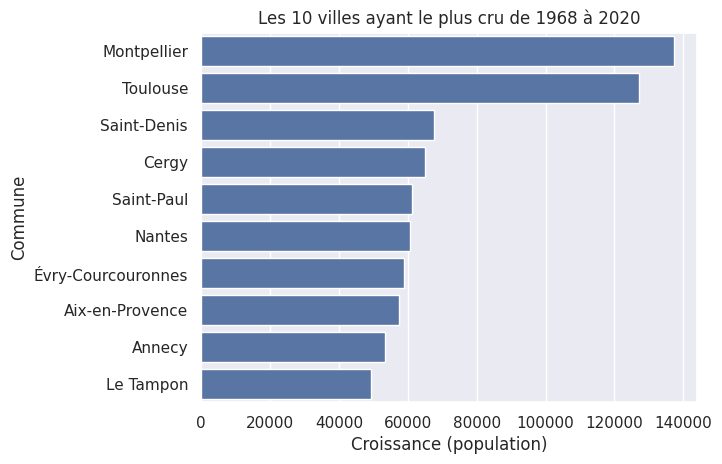

In [351]:
sns.barplot(data=res, y="Commune", x="Croissance")
plt.xlabel("Croissance (population)")
plt.title("Les 10 villes ayant le plus cru de 1968 à 2020")
plt.show()

### B. Par Département

In [352]:
res = query_to_dataframe(
"""WITH Pop1968_Dep AS (
    SELECT c.codeDepartement, SUM(s.populationDebut) AS population_1968
    FROM Statistiques s
    JOIN Communes c ON s.codeCommune = c.codeCommune
    WHERE s.anneeInf = 1968
		AND c.nomCommune NOT LIKE "%Arrondissement%"
    GROUP BY c.codeDepartement),
Pop2020_Dep AS (
    SELECT c.codeDepartement, SUM(s.populationFin) AS population_2020
    FROM Statistiques s
    JOIN Communes c ON s.codeCommune = c.codeCommune
    WHERE s.anneeSup = 2020
		AND c.nomCommune NOT LIKE "%Arrondissement%"
    GROUP BY c.codeDepartement)
SELECT
    d.nomDepartement AS Departement,
    (Pop2020_Dep.population_2020 - Pop1968_Dep.population_1968) AS Croissance
FROM Pop1968_Dep
JOIN Pop2020_Dep ON Pop1968_Dep.codeDepartement = Pop2020_Dep.codeDepartement
JOIN Departements d ON d.codeDepartement = Pop1968_Dep.codeDepartement
ORDER BY croissance DESC
LIMIT 10;
""")

res

,Departement,Croissance
0,Seine-et-Marne,824296
1,Haute-Garonne,725045
2,Essonne,632793
3,Gironde,627001
4,Hérault,597576
5,Yvelines,595341
6,Loire-Atlantique,583089
7,Bouches-du-Rhône,577799
8,Val-d'Oise,558535
9,Rhône,557054


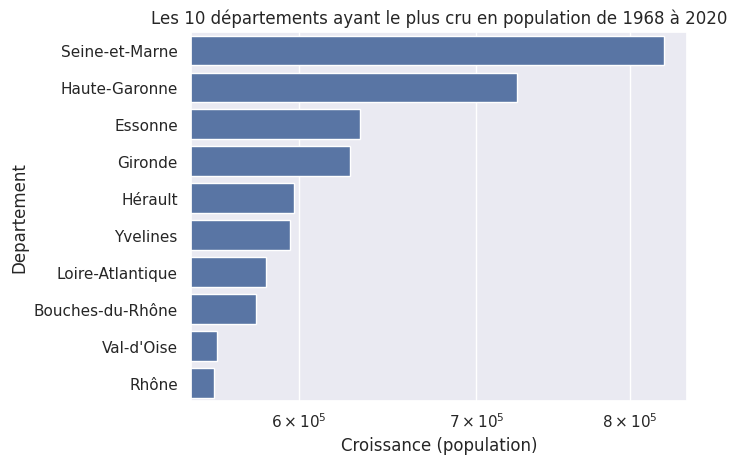

In [353]:
sns.barplot(data=res, y="Departement", x="Croissance")
plt.xlabel("Croissance (population)")
plt.xscale("log")
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:g}'))
plt.grid(visible=True, which="both", axis="x", linestyle="-", color="white")
plt.title("Les 10 départements ayant le plus cru en population de 1968 à 2020")
plt.show()

### C. Par Région

In [354]:
res = query_to_dataframe(
"""WITH Pop1968_Reg AS (
    SELECT d.codeRegion, SUM(s.populationDebut) AS population_1968
    FROM Statistiques s
    JOIN Communes c ON s.codeCommune = c.codeCommune
    JOIN Departements d ON c.codeDepartement = d.codeDepartement
    WHERE s.anneeInf = 1968
		AND c.nomCommune NOT LIKE "%Arrondissement%"
    GROUP BY d.codeRegion),
Pop2020_Reg AS (
    SELECT d.codeRegion, SUM(s.populationFin) AS population_2020
    FROM Statistiques s
    JOIN Communes c ON s.codeCommune = c.codeCommune
    JOIN Departements d ON c.codeDepartement = d.codeDepartement
    WHERE s.anneeSup = 2020
		AND c.nomCommune NOT LIKE "%Arrondissement%"
    GROUP BY d.codeRegion)
SELECT
    r.nomRegion AS Region,
    (Pop2020_Reg.population_2020 - Pop1968_Reg.population_1968) AS Croissance
FROM Pop1968_Reg
JOIN Pop2020_Reg ON Pop1968_Reg.codeRegion = Pop2020_Reg.codeRegion
JOIN Regions r ON r.codeRegion = Pop1968_Reg.codeRegion
ORDER BY croissance DESC
LIMIT 10;
""")

res

,Region,Croissance
0,Île-de-France,3023163
1,Auvergne-Rhône-Alpes,2343654
2,Occitanie,2081625
3,Provence-Alpes-Côte d'Azur,1799830
4,Nouvelle-Aquitaine,1356957
5,Pays de la Loire,1249254
6,Bretagne,905608
7,Hauts-de-France,603356
8,Grand Est,596478
9,Centre-Val de Loire,584625


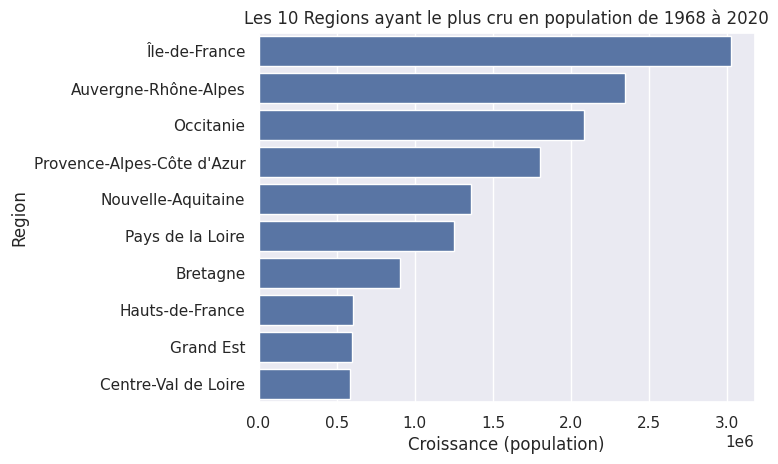

In [355]:
sns.barplot(data=res, y="Region", x="Croissance")
plt.xlabel("Croissance (population)")
plt.title("Les 10 Regions ayant le plus cru en population de 1968 à 2020")
plt.show()

## 6. Liste des 10 villes / départements où on nait / meurt le plus. 

### A.1 Villes ayant eu le plus de naissances

In [356]:
res = query_to_dataframe(
"""
WITH MaxNaissancesParVille AS (
    SELECT 
        s.codeCommune,
        MAX(s.naissances) AS max_naissances
    FROM Statistiques s
    GROUP BY s.codeCommune)
SELECT 
    c.nomCommune AS Commune,
    s.anneeInf,
    s.anneeSup,
    (s.naissances / (s.anneeSup - s.anneeInf)) AS Naissances
FROM MaxNaissancesParVille m
JOIN Statistiques s ON s.codeCommune = m.codeCommune AND s.naissances = m.max_naissances
JOIN Communes c ON c.codeCommune = s.codeCommune
ORDER BY s.naissances DESC
LIMIT 10;
""")

res

,Commune,anneeInf,anneeSup,Naissances
0,Paris,1999,2009,31522.0000
1,Marseille,1999,2009,11530.1000
2,Lyon,1999,2009,7111.4000
3,Toulouse,1999,2009,5772.4000
4,Nice,1999,2009,4230.7000
5,Strasbourg,1999,2009,3879.7000
6,Nantes,1999,2009,3828.9000
7,Lille,1999,2009,3686.9000
8,Montpellier,1999,2009,3428.6000
9,Paris 18e Arrondissement,1999,2009,3376.0000


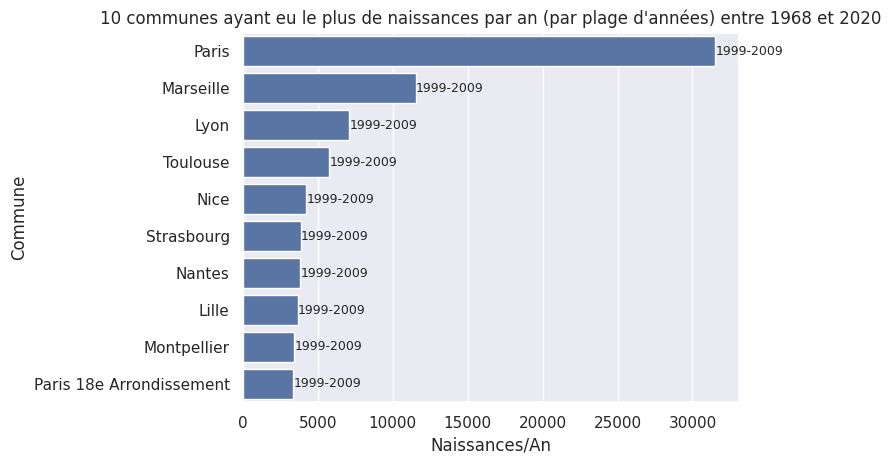

In [357]:
sns.barplot(data=res, x="Naissances", y="Commune")
plt.xlabel("Naissances/An")
plt.title("10 communes ayant eu le plus de naissances par an (par plage d'années) entre 1968 et 2020")
for i, row in res.iterrows():
    plt.text(
        row["Naissances"],
        i,
        f"{row['anneeInf']}-{row['anneeSup']}",
        va="center",
        ha="left",
        fontsize=9)

### A.2 Villes ayant eu le plus de décès

In [358]:
res = query_to_dataframe(
"""WITH MaxDecesParVille AS (
    SELECT 
        s.codeCommune,
        MAX(s.deces) AS max_deces
    FROM Statistiques s
    GROUP BY s.codeCommune)
SELECT 
    c.nomCommune AS Commune,
    s.anneeInf,
    s.anneeSup,
    (s.deces / (s.anneeSup - s.anneeInf)) AS Deces
FROM MaxDecesParVille m
JOIN Statistiques s ON s.codeCommune = m.codeCommune AND s.deces = m.max_deces
JOIN Communes c ON c.codeCommune = s.codeCommune
ORDER BY s.deces DESC
LIMIT 10;
""")

res

,Commune,anneeInf,anneeSup,Deces
0,Paris,1968,1975,27868.1429
1,Marseille,1990,1999,8770.4444
2,Nice,1990,1999,4431.5556
3,Lyon,1968,1975,5405.5714
4,Toulouse,1999,2009,2738.1000
5,Bordeaux,1968,1975,3202.1429
6,Lille,1968,1975,2826.4286
7,Paris 18e Arrondissement,1968,1975,2772.0000
8,Strasbourg,1999,2009,1918.7000
9,Nantes,1999,2009,1915.6000


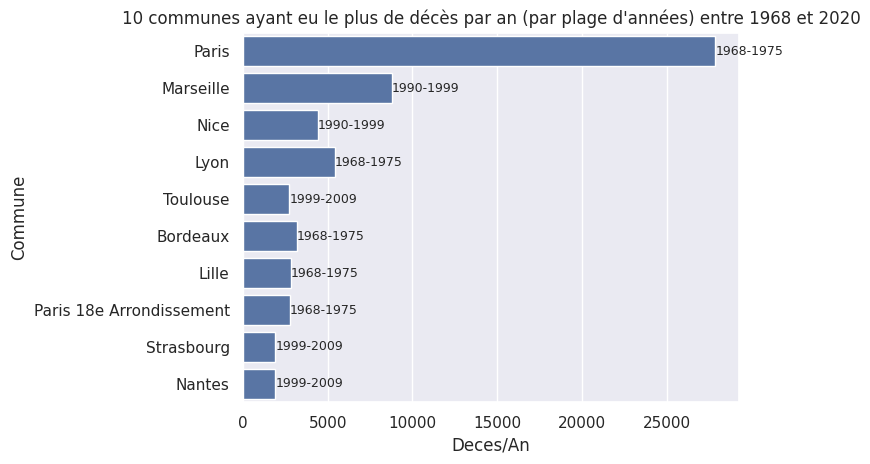

In [359]:
sns.barplot(data=res, x="Deces", y="Commune")
plt.xlabel("Deces/An")
plt.title("10 communes ayant eu le plus de décès par an (par plage d'années) entre 1968 et 2020")
for i, row in res.iterrows():
    plt.text(
        row["Deces"],
        i,
        f"{row['anneeInf']}-{row['anneeSup']}",
        va="center",
        ha="left",
        fontsize=9)

### B.2 Par départements ayant eu le plus de décès

In [360]:
res = query_to_dataframe(
"""WITH MaxDecesParDepartement AS (
    SELECT d.codeDepartement,
           MAX(s.deces) AS max_deces
    FROM Statistiques s
    JOIN Communes c ON s.codeCommune = c.codeCommune
    JOIN Departements d ON c.codeDepartement = d.codeDepartement
	WHERE c.nomCommune NOT LIKE "%Arrondissement%"
    GROUP BY d.codeDepartement)
SELECT 
    d.nomDepartement as Departement,
    s.anneeInf,
    s.anneeSup,
    (s.deces/(s.anneeSup - s.anneeInf)) AS Deces
FROM MaxDecesParDepartement m
JOIN Departements d ON d.codeDepartement = m.codeDepartement
JOIN Communes c ON c.codeDepartement = d.codeDepartement
JOIN Statistiques s ON s.codeCommune = c.codeCommune 
WHERE s.deces = m.max_deces
ORDER BY s.deces DESC
LIMIT 10;
""")

res

,Departement,anneeInf,anneeSup,Deces
0,Paris,1968,1975,27868.1429
1,Bouches-du-Rhône,1990,1999,8770.4444
2,Alpes-Maritimes,1990,1999,4431.5556
3,Rhône,1968,1975,5405.5714
4,Haute-Garonne,1999,2009,2738.1000
5,Gironde,1968,1975,3202.1429
6,Nord,1968,1975,2826.4286
7,Bas-Rhin,1999,2009,1918.7000
8,Loire-Atlantique,1999,2009,1915.6000
9,Var,1999,2009,1795.0000


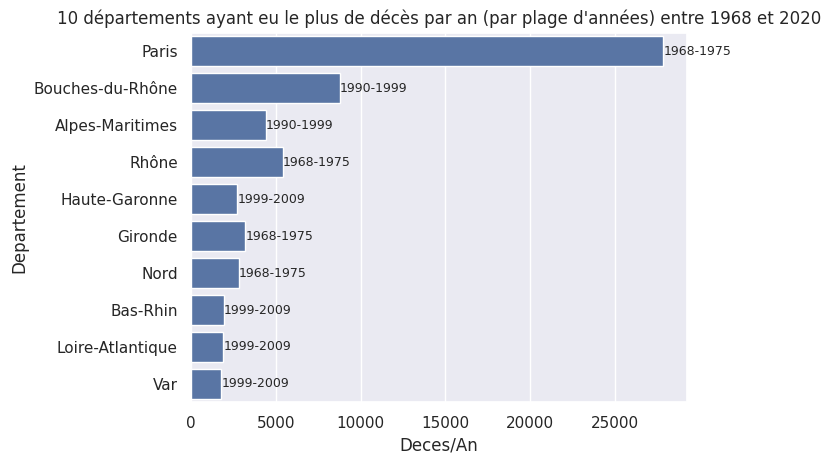

In [361]:
sns.barplot(data=res, x="Deces", y="Departement")
plt.xlabel("Deces/An")
plt.title("10 départements ayant eu le plus de décès par an (par plage d'années) entre 1968 et 2020")
for i, row in res.iterrows():
    plt.text(
        row["Deces"],
        i,
        f"{row['anneeInf']}-{row['anneeSup']}",
        va="center",
        ha="left",
        fontsize=9)

### B.1 Par Départements ayant eu le plus de naissances

In [362]:
res = query_to_dataframe(
"""WITH MaxNaissancesParDepartement AS (
    SELECT d.codeDepartement,
           MAX(s.naissances) AS max_naissances
    FROM Statistiques s
    JOIN Communes c ON s.codeCommune = c.codeCommune
    JOIN Departements d ON c.codeDepartement = d.codeDepartement
	WHERE c.nomCommune NOT LIKE "%Arrondissement%"
    GROUP BY d.codeDepartement)
SELECT 
    d.nomDepartement AS Departement,
    s.anneeInf,
    s.anneeSup,
    (s.naissances / (s.anneeSup - s.anneeInf)) as Naissances
FROM MaxNaissancesParDepartement m
JOIN Departements d ON d.codeDepartement = m.codeDepartement
JOIN Communes c ON c.codeDepartement = d.codeDepartement
JOIN Statistiques s ON s.codeCommune = c.codeCommune 
WHERE s.naissances = m.max_naissances
ORDER BY s.naissances DESC
LIMIT 10;""")

res

,Departement,anneeInf,anneeSup,Naissances
0,Paris,1999,2009,31522.0000
1,Bouches-du-Rhône,1999,2009,11530.1000
2,Rhône,1999,2009,7111.4000
3,Haute-Garonne,1999,2009,5772.4000
4,Alpes-Maritimes,1999,2009,4230.7000
5,Bas-Rhin,1999,2009,3879.7000
6,Loire-Atlantique,1999,2009,3828.9000
7,Nord,1999,2009,3686.9000
8,Hérault,1999,2009,3428.6000
9,Ille-et-Vilaine,1968,1975,4328.4286


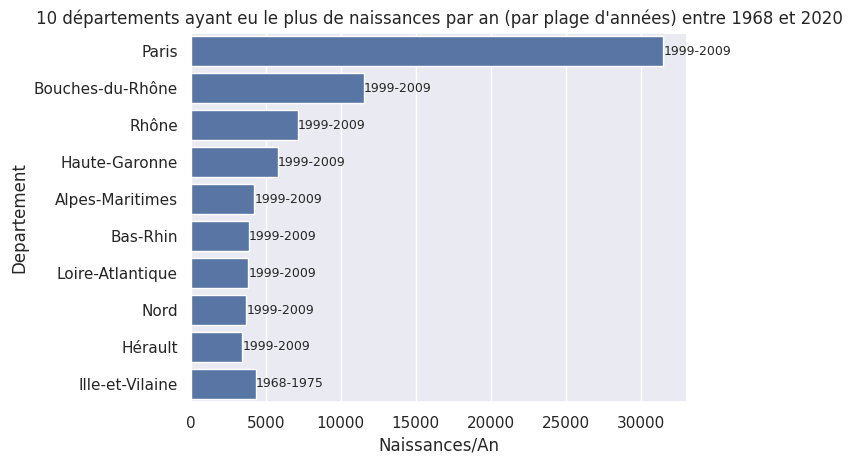

In [363]:
sns.barplot(data=res, x="Naissances", y="Departement")
plt.xlabel("Naissances/An")
plt.title("10 départements ayant eu le plus de naissances par an (par plage d'années) entre 1968 et 2020")
for i, row in res.iterrows():
    plt.text(
        row["Naissances"],
        i,
        f"{row['anneeInf']}-{row['anneeSup']}",
        va="center",
        ha="left",
        fontsize=9)

## 7. Liste des 10 villes / départements avec la plus grande/petite densité.

### A.1 Par ville ayant eu la plus grande densité

In [364]:
res = query_to_dataframe(
"""WITH Densities AS (
    SELECT 
        c.nomCommune AS Ville,
        s.anneeSup AS Annee,
        (s.populationFin / c.superficie) AS Densite
    FROM Statistiques s
    JOIN Communes c ON c.codeCommune = s.codeCommune)
SELECT d1.Ville, d1.Annee, d1.Densite
FROM Densities d1
JOIN (
    SELECT Ville, MAX(Densite) AS MaxDensite
    FROM Densities
    GROUP BY Ville) d2
ON d1.Ville = d2.Ville AND d1.Densite = d2.MaxDensite
ORDER BY d1.Densite DESC
LIMIT 10;""")

res

,Ville,Annee,Densite
0,Marseille 1er Arrondissement,1975,25692.778458
1,Marseille 5e Arrondissement,1975,23573.214185
2,Marseille 6e Arrondissement,1975,22695.715316
3,Marseille 3e Arrondissement,2020,20106.539199
4,Marseille 4e Arrondissement,1975,19804.826935
5,Grenoble,1975,9158.136111
6,Marseille 7e Arrondissement,1975,8104.482492
7,Sainte-Foy-la-Grande,1975,6558.823652
8,Marseille 2e Arrondissement,1975,6542.460367
9,Marseille 15e Arrondissement,1975,5715.207230


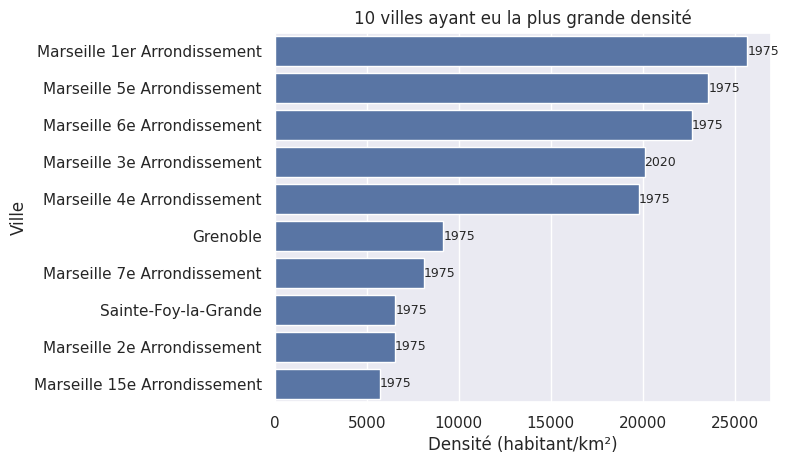

In [365]:
sns.barplot(data=res, x="Densite", y="Ville")
plt.title("10 villes ayant eu la plus grande densité")
plt.xlabel("Densité (habitant/km²)")
for i, row in res.iterrows():
    plt.text(
        row["Densite"],
        i,
        row['Annee'],
        va="center",
        ha="left",
        fontsize=9)

### A.2 Par ville ayant eu la plus petite densité

In [366]:
res = query_to_dataframe(
"""WITH Densities AS (
    SELECT 
        c.nomCommune AS Ville,
        s.anneeInf AS Annee,
        (s.populationDebut / c.superficie) AS Densite
    FROM Statistiques s
    JOIN Communes c ON c.codeCommune = s.codeCommune)
SELECT d1.Ville, d1.Annee, d1.Densite
FROM Densities d1
JOIN (
    SELECT Ville, MAX(Densite) AS MaxDensite
    FROM Densities
    GROUP BY Ville) d2
ON d1.Ville = d2.Ville AND d1.Densite = d2.MaxDensite
ORDER BY d1.Densite ASC
LIMIT 10;""")

res

,Ville,Annee,Densite
0,Rochefourchat,1968,0.470958
1,Majastres,1968,0.670017
2,Izon-la-Bruisse,1999,0.955631
3,Saint-Christophe-en-Oisans,2009,0.996193
4,Blieux,1982,1.038732
5,Blieux,2014,1.038732
6,Blieux,1968,1.038732
7,Blieux,1999,1.038732
8,Aulan,1982,1.042654
9,Châteauneuf-d'Oze,1968,1.067480


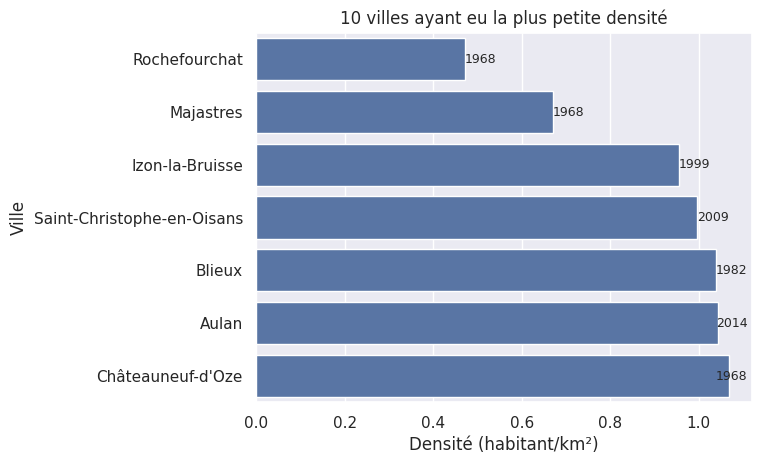

In [367]:
sns.barplot(data=res, x="Densite", y="Ville")
plt.title("10 villes ayant eu la plus petite densité")
plt.xlabel("Densité (habitant/km²)")
for i, row in res.iterrows():
    plt.text(
        row["Densite"],
        i,
        row['Annee'],
        va="center",
        ha="left",
        fontsize=9)
    if i > 5: break

### B.1 Par département ayant eu la plus grande densité

In [368]:
res = query_to_dataframe(
"""WITH Densities AS (
    SELECT 
        d.nomDepartement AS Departement,
        s.anneeSup AS Annee,
        (SUM(s.populationFin) / SUM(c.superficie)) AS Densite
    FROM Statistiques s
    JOIN Communes c ON c.codeCommune = s.codeCommune
    JOIN Departements d ON d.codeDepartement = c.codeDepartement
    GROUP BY d.nomDepartement, s.anneeSup
)
SELECT d1.Departement, d1.Annee, d1.Densite
FROM Densities d1
JOIN (
    SELECT Departement, MAX(Densite) AS MaxDensite
    FROM Densities
    GROUP BY Departement
) d2
ON d1.Departement = d2.Departement AND d1.Densite = d2.MaxDensite
ORDER BY d1.Densite DESC
LIMIT 10;
""")

res

,Departement,Annee,Densite
0,Bouches-du-Rhône,2020,547.734754
1,Loire-Atlantique,2020,257.573640
2,Alpes-Maritimes,2020,255.295936
3,Haute-Garonne,2020,224.390665
4,Hérault,2020,194.881339
5,Isère,2020,171.905365
6,Gironde,2020,164.039520
7,Loire,2020,160.755890
8,Ille-et-Vilaine,2020,160.723247
9,Finistère,2020,136.221447


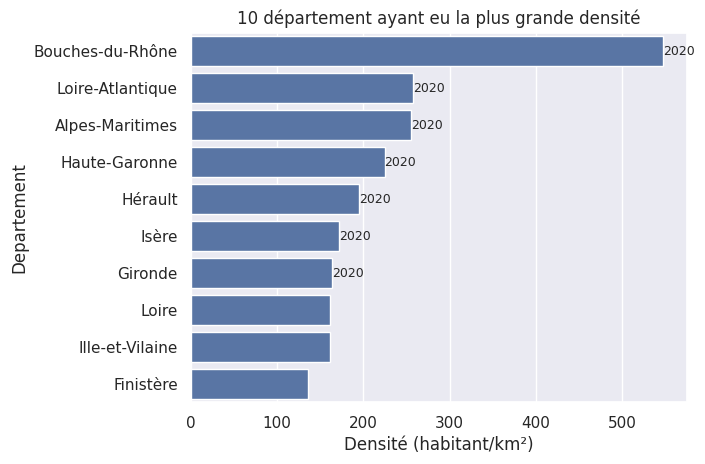

In [369]:
sns.barplot(data=res, x="Densite", y="Departement")
plt.title("10 département ayant eu la plus grande densité")
plt.xlabel("Densité (habitant/km²)")
for i, row in res.iterrows():
    plt.text(
        row["Densite"],
        i,
        row['Annee'],
        va="center",
        ha="left",
        fontsize=9)
    if i > 5: break

### B.2 Départements ayant eu la plus petite densité

In [370]:
res = query_to_dataframe(
"""WITH Densities AS (
    SELECT 
        d.nomDepartement AS Departement,
        s.anneeInf AS Annee,
        (SUM(s.populationDebut) / SUM(c.superficie)) AS Densite
    FROM Statistiques s
    JOIN Communes c ON c.codeCommune = s.codeCommune
    JOIN Departements d ON d.codeDepartement = c.codeDepartement
    GROUP BY d.nomDepartement, s.anneeInf)
SELECT d1.Departement, d1.Annee, d1.Densite
FROM Densities d1
JOIN (
    SELECT Departement, MAX(Densite) AS MaxDensite
    FROM Densities
    GROUP BY Departement) d2
ON d1.Departement = d2.Departement AND d1.Densite = d2.MaxDensite
ORDER BY d1.Densite ASC
LIMIT 10;
""")

res

,Departement,Annee,Densite
0,Alpes-de-Haute-Provence,2014,23.333266
1,Hautes-Alpes,2014,25.210140
2,Creuse,1968,28.187833
3,Cantal,1968,29.572230
4,Gers,2014,30.466755
5,Ariège,2014,31.201737
6,Aveyron,1968,32.234016
7,Indre,1975,36.597930
8,Haute-Corse,2014,36.985834
9,Corse-du-Sud,2014,37.778697


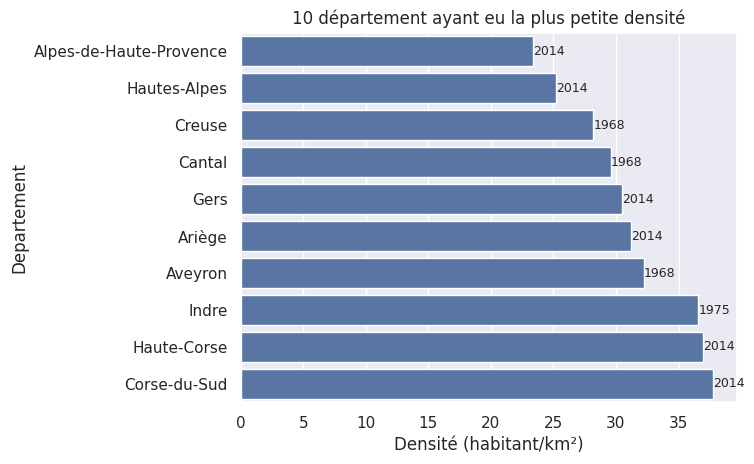

In [371]:
sns.barplot(data=res, x="Densite", y="Departement")
plt.title("10 département ayant eu la plus petite densité")
plt.xlabel("Densité (habitant/km²)")
for i, row in res.iterrows():
    plt.text(
        row["Densite"],
        i,
        row['Annee'],
        va="center",
        ha="left",
        fontsize=9)

## 8. Comparaison pour 2020 des naissances / décès / mouvements de population par département / région (2 requêtes). (Mouvements =deltapop(1968/2020)-(nais-deces)). 

In [372]:
res = query_to_dataframe(
"""WITH Populations1968 AS (
    SELECT 
        r.nomRegion AS Region,
        SUM(s.populationDebut) AS Population1968
    FROM Statistiques s
    JOIN Communes c ON c.codeCommune = s.codeCommune
    JOIN Departements d ON d.codeDepartement = c.codeDepartement
    JOIN Regions r ON d.codeRegion = r.codeRegion
    WHERE s.anneeInf = 1968
		AND c.nomCommune NOT LIKE "%Arrondissement%"
    GROUP BY r.nomRegion),
Populations2020 AS (
    SELECT 
        r.nomRegion AS Region,
        SUM(s.populationFin) AS Population2020
    FROM Statistiques s
    JOIN Communes c ON c.codeCommune = s.codeCommune
    JOIN Departements d ON d.codeDepartement = c.codeDepartement
    JOIN Regions r ON d.codeRegion = r.codeRegion
    WHERE s.anneeSup = 2020
		AND c.nomCommune NOT LIKE "%Arrondissement%"
    GROUP BY r.nomRegion),
TotalNaissances AS (
    SELECT 
        r.nomRegion AS Region,
        SUM(s.naissances) AS TotalNaissances
    FROM Statistiques s
    JOIN Communes c ON c.codeCommune = s.codeCommune
    JOIN Departements d ON d.codeDepartement = c.codeDepartement
    JOIN Regions r ON d.codeRegion = r.codeRegion
    WHERE c.nomCommune NOT LIKE "%Arrondissement%"
    GROUP BY r.nomRegion),
TotalDeces AS (
    SELECT 
        r.nomRegion AS Region,
        SUM(s.deces) AS TotalDeces
    FROM Statistiques s
    JOIN Communes c ON c.codeCommune = s.codeCommune
    JOIN Departements d ON d.codeDepartement = c.codeDepartement
    JOIN Regions r ON d.codeRegion = r.codeRegion
    WHERE c.nomCommune NOT LIKE "%Arrondissement%"
    GROUP BY r.nomRegion)
SELECT 
    p2020.Region,
    tn.TotalNaissances AS Naissances,
    td.TotalDeces AS Deces,
    ((p2020.Population2020 - p1968.Population1968) - (tn.TotalNaissances - td.TotalDeces)) AS Mouvements
FROM Populations1968 p1968
JOIN Populations2020 p2020 ON p2020.Region = p1968.Region
JOIN TotalNaissances tn ON tn.Region = p1968.Region
JOIN TotalDeces td ON td.Region = p1968.Region
ORDER BY Mouvements DESC;
""")

res

,Region,Naissances,Deces,Mouvements
0,Occitanie,2828097,2615086,1868614
1,Provence-Alpes-Côte d'Azur,2763248,2292607,1329189
2,Nouvelle-Aquitaine,3059785,3018417,1315589
3,Auvergne-Rhône-Alpes,4699862,3239520,883312
4,Bretagne,1899528,1593024,599104
5,Pays de la Loire,2263746,1500467,485975
6,Centre-Val de Loire,1550999,1262349,295975
7,Corse,146807,143069,134695
8,Guyane,213699,31177,58219
9,Bourgogne-Franche-Comté,1782652,1468954,-7382


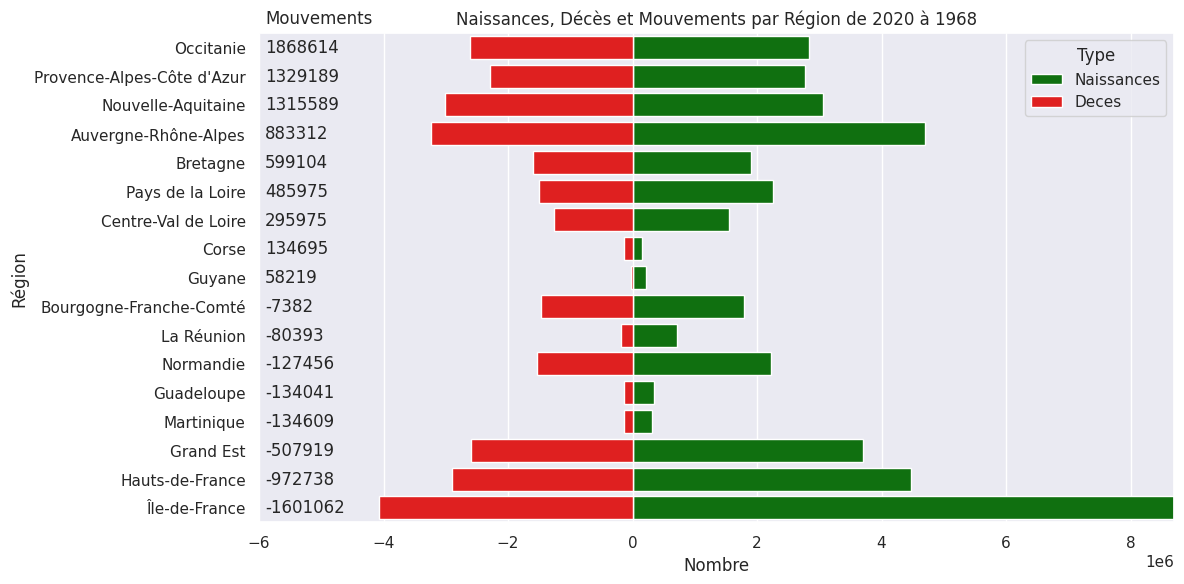

In [373]:
melted = pd.melt(
    res,
    id_vars="Region",
    value_vars=["Naissances", "Deces"],
    var_name="Type",
    value_name="Count",
)

melted.loc[melted["Type"] == "Deces", "Count"] *= -1

plt.figure(figsize=(12, 6))

sns.barplot(
    data=melted,
    y="Region",
    x="Count",
    hue="Type",
    palette={"Naissances": "green", "Deces": "red"},
    dodge=False,
)

plt.axvline(0, color="white", linewidth=0.8, linestyle="-")

plt.text(
    x=-5.9e6,
    y=-1,
    s="Mouvements",
    va="center",
    ha="left",
)

for i, row in res.iterrows():
    plt.text(
        x=-5.9e6,
        y=i,
        s=f"{row['Mouvements']}",
        va="center",
        ha="left",
    )

plt.xlim(-6e6, res["Naissances"].max())

plt.title("Naissances, Décès et Mouvements par Région de 2020 à 1968")
plt.xlabel("Nombre")
plt.ylabel("Région")

plt.legend(title="Type", loc="upper right")

plt.tight_layout()
plt.show()


## 9.  Comparaison par recensement des naissances / décès / mouvements de population de la France

In [374]:
res = query_to_dataframe(
"""WITH Populations1968 AS (
    SELECT SUM(s.populationDebut) AS Population1968
    FROM Statistiques s
    JOIN Communes c ON c.codeCommune = s.codeCommune
    WHERE s.anneeInf = 1968
		AND c.nomCommune NOT LIKE "%Arrondissement%"),
Populations2020 AS (
    SELECT SUM(s.populationFin) AS Population2020
    FROM Statistiques s
    JOIN Communes c ON c.codeCommune = s.codeCommune
    WHERE s.anneeSup = 2020
		AND c.nomCommune NOT LIKE "%Arrondissement%"),
TotalNaissances AS (
    SELECT SUM(s.naissances) AS TotalNaissances
    FROM Statistiques s
    JOIN Communes c ON c.codeCommune = s.codeCommune
		AND c.nomCommune NOT LIKE "%Arrondissement%"),
TotalDeces AS (
    SELECT SUM(s.deces) AS TotalDeces
    FROM Statistiques s
    JOIN Communes c ON c.codeCommune = s.codeCommune
		AND c.nomCommune NOT LIKE "%Arrondissement%")
SELECT
    Populations2020.Population2020,
    Populations1968.Population1968,
    (Populations2020.Population2020 - Populations1968.Population1968) AS DeltaPop,
    TotalNaissances.TotalNaissances AS Naissances1968_2020,
    TotalDeces.TotalDeces AS Deces1968_2020,
    ((Populations2020.Population2020 - Populations1968.Population1968) - (TotalNaissances.TotalNaissances - TotalDeces.TotalDeces)) AS Mouvements
FROM Populations1968, Populations2020, TotalNaissances, TotalDeces;
""")

res

,Population2020,Population1968,DeltaPop,Naissances1968_2020,Deces1968_2020,Mouvements
0,67162154,50798112,16364042,41681871,28722901,3405072


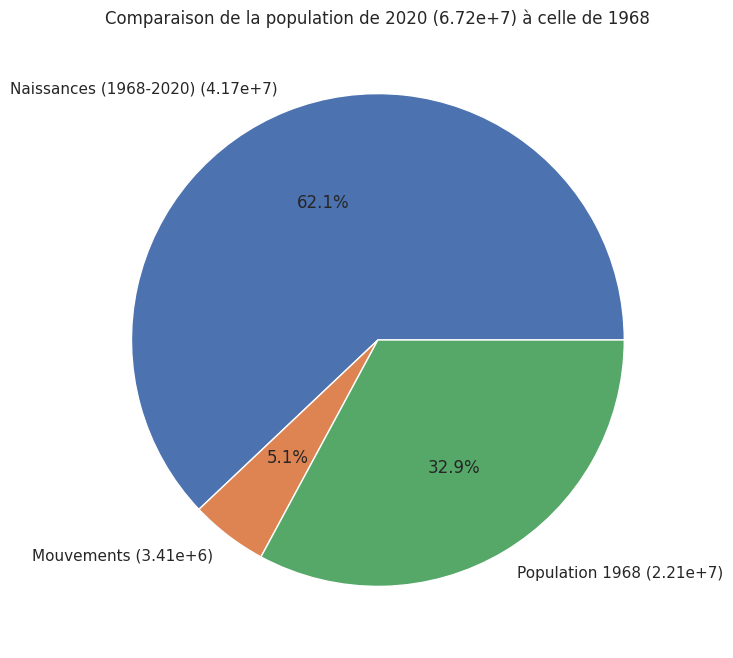

In [375]:
res["Population1968"] = res["Population1968"] - res["Deces1968_2020"]
population_2020 = res["Population2020"].iloc[0]
melted = pd.melt(res, 
                 value_vars=['Naissances1968_2020', 'Mouvements', 'Population1968'], 
                 var_name='Categorie', 
                 value_name='Valeurs')

melted['Categorie'] = melted['Categorie'] + " (" + melted['Valeurs'].apply(lambda x: f"{x:.2e}") + ")"
melted['Categorie'] = melted['Categorie'].apply(lambda x: x.replace('1968', ' 1968'))
melted['Categorie'] = melted['Categorie'].apply(lambda x: x.replace('1968_2020', '(1968-2020)'))

plt.figure(figsize=(8, 8))
plt.pie(melted['Valeurs'], 
        labels=melted['Categorie'], 
        autopct='%1.1f%%')

plt.title(f"Comparaison de la population de 2020 ({population_2020:.2e}) à celle de 1968")
plt.show()


## 10. Requêtes supplémentaires

### A. Mouvements de population par Region

In [376]:
res = query_to_dataframe(
"""WITH Populations1968 AS (
    SELECT 
        r.nomRegion AS Region,
        SUM(s.populationDebut) AS Population1968
    FROM Statistiques s JOIN Communes c ON c.codeCommune = s.codeCommune
                        JOIN Departements d ON d.codeDepartement = c.codeDepartement
                        JOIN Regions r ON d.codeRegion = r.codeRegion
    WHERE s.anneeInf = 1968
        AND c.nomCommune NOT LIKE "%Arrondissement%"
    GROUP BY r.nomRegion),
Populations2020 AS (
    SELECT 
        r.nomRegion AS Region,
        SUM(s.populationFin) AS Population2020
    FROM Statistiques s JOIN Communes c ON c.codeCommune = s.codeCommune
                        JOIN Departements d ON d.codeDepartement = c.codeDepartement
                        JOIN Regions r ON d.codeRegion = r.codeRegion
    WHERE s.anneeSup = 2020 AND c.nomCommune NOT LIKE "%Arrondissement%"
    GROUP BY r.nomRegion),
TotalNaissances AS (
    SELECT 
        r.nomRegion AS Region,
        SUM(s.naissances) AS TotalNaissances
    FROM Statistiques s JOIN Communes c ON c.codeCommune = s.codeCommune
                        JOIN Departements d ON d.codeDepartement = c.codeDepartement
                        JOIN Regions r ON d.codeRegion = r.codeRegion
    WHERE c.nomCommune NOT LIKE "%Arrondissement%"
    GROUP BY r.nomRegion),
TotalDeces AS (
    SELECT 
        r.nomRegion AS Region,
        SUM(s.deces) AS TotalDeces
    FROM Statistiques s JOIN Communes c ON c.codeCommune = s.codeCommune
                        JOIN Departements d ON d.codeDepartement = c.codeDepartement
                        JOIN Regions r ON d.codeRegion = r.codeRegion
    WHERE c.nomCommune NOT LIKE "%Arrondissement%"
    GROUP BY r.nomRegion)
SELECT 
    p2020.Region,
    ((p2020.Population2020 - p1968.Population1968) - (tn.TotalNaissances - td.TotalDeces)) AS Mouvements
FROM Populations1968 p1968 JOIN Populations2020 p2020 ON p2020.Region = p1968.Region
                           JOIN TotalNaissances tn ON tn.Region = p1968.Region
                           JOIN TotalDeces td ON td.Region = p1968.Region
ORDER BY Mouvements ASC;
""")

res

,Region,Mouvements
0,Île-de-France,-1601062
1,Hauts-de-France,-972738
2,Grand Est,-507919
3,Martinique,-134609
4,Guadeloupe,-134041
5,Normandie,-127456
6,La Réunion,-80393
7,Bourgogne-Franche-Comté,-7382
8,Guyane,58219
9,Corse,134695


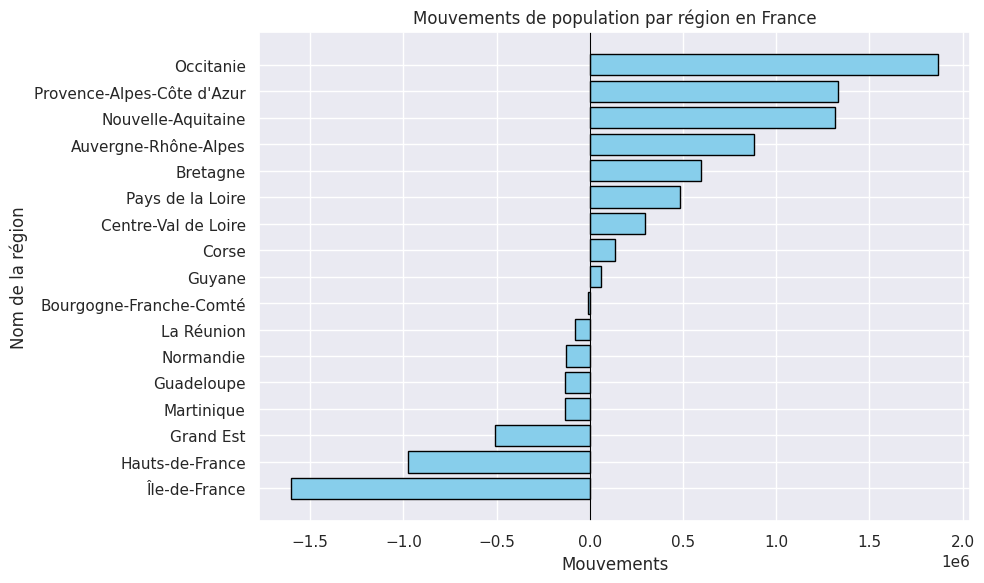

In [377]:
plt.figure(figsize=(10, 6))
plt.barh(res["Region"], res["Mouvements"], color='skyblue', edgecolor='black')
plt.axvline(0, color='black', linewidth=0.8)
plt.xlabel("Mouvements")
plt.ylabel("Nom de la région")
plt.title("Mouvements de population par région en France")
plt.tight_layout()
plt.show()

### B.1 10 communes ayant eu le plus fort Taux de Croissance Annuel Moyen

In [378]:
res = query_to_dataframe(
"""SELECT 
    c.nomCommune,
    POWER((SUM(s2.populationFin) / SUM(s1.populationDebut)), 1 / (2020 - 1968)) - 1 AS TCAM_Population
FROM Statistiques s1
JOIN Statistiques s2 ON s1.codeCommune = s2.codeCommune
JOIN Communes c ON s1.codeCommune = c.codeCommune
WHERE s1.anneeInf = 1968
    AND s2.anneeSup = 2020
    AND c.superficie IS NOT NULL
GROUP BY c.nomCommune, c.superficie
ORDER BY TCAM_Population DESC
LIMIT 10;
""")
res["TCAM_Population"] *= 100
res

,nomCommune,TCAM_Population
0,La Grande-Motte,10.174542
1,Villefontaine,7.388179
2,Val-de-Reuil,6.886502
3,Juvignac,6.787424
4,Jacou,6.581375
5,Méjannes-le-Clap,6.249395
6,L'Isle-d'Abeau,6.220437
7,Poulx,6.120141
8,Saint-Clément-de-Rivière,6.067153
9,Roquettes,5.754995


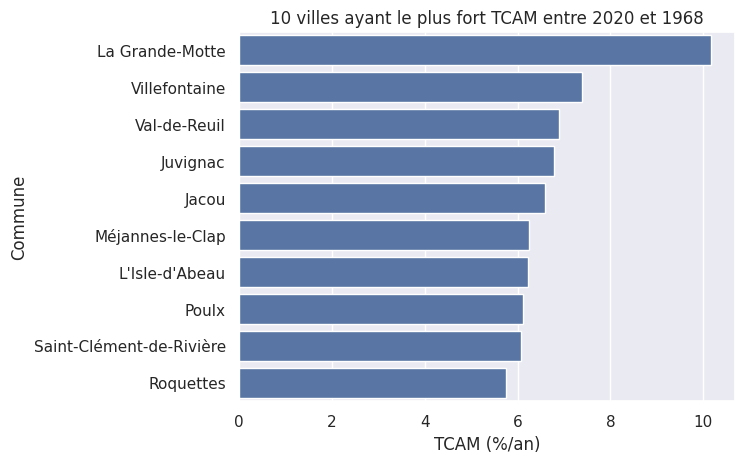

In [379]:
sns.barplot(data=res, x="TCAM_Population", y="nomCommune")
plt.title("10 villes ayant le plus fort TCAM entre 2020 et 1968")
plt.xlabel("TCAM (%/an)")
plt.ylabel("Commune")
plt.show()

### B.1 10 communes ayant eu le plus faible Taux de Croissance Annuel Moyen

In [380]:
res = query_to_dataframe(
"""SELECT 
    c.nomCommune,
    POWER((SUM(s2.populationFin) / SUM(s1.populationDebut)), 1 / (2020 - 1968)) - 1 AS TCAM_Population
FROM Statistiques s1
JOIN Statistiques s2 ON s1.codeCommune = s2.codeCommune
JOIN Communes c ON s1.codeCommune = c.codeCommune
WHERE s1.anneeInf = 1968
    AND s2.anneeSup = 2020
    AND c.superficie IS NOT NULL
GROUP BY c.nomCommune, c.superficie
ORDER BY TCAM_Population ASC
LIMIT 10;
""")
res["TCAM_Population"] *= 100
res

,nomCommune,TCAM_Population
0,Tarrano,-3.935357
1,Rochefourchat,-3.387003
2,La Bâtie-des-Fonds,-3.225206
3,Le Fau,-3.200875
4,Saint-Martin-des-Puits,-3.138591
5,Majastres,-3.047666
6,Laprugne,-2.853668
7,Saint-Vincent-de-Salers,-2.780491
8,Saint-Paul-de-Salers,-2.780491
9,Lapège,-2.722044


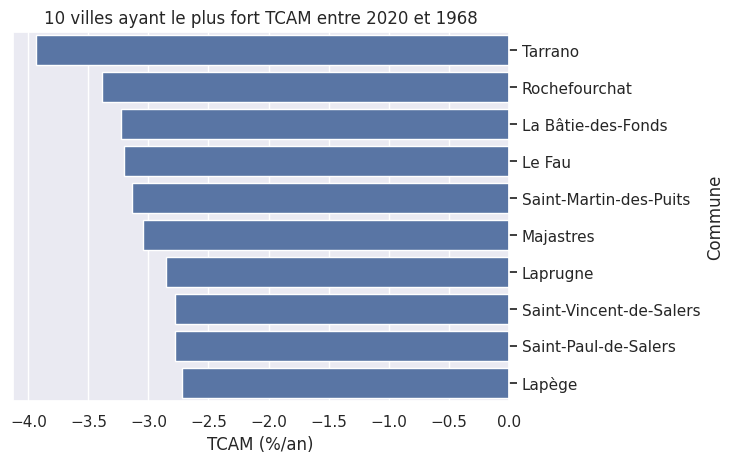

In [381]:
sns.barplot(data=res, x="TCAM_Population", y="nomCommune")
plt.title("10 villes ayant le plus fort TCAM entre 2020 et 1968")
plt.xlabel("TCAM (%/an)")
ax = plt.gca()
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
plt.ylabel("Commune")
plt.show()

### C. 10 Départements avec le plus grand nombre de logements en 2020

In [382]:
res = query_to_dataframe(
"""
    SELECT d.nomDepartement, SUM(s.logementsFin) AS TotalLogements
    FROM Departements d JOIN Communes c ON d.codeDepartement = c.codeDepartement
                        JOIN Statistiques s ON c.codeCommune = s.codeCommune
    WHERE s.anneeSup = 2020
    GROUP BY d.nomDepartement
    ORDER BY TotalLogements DESC
    LIMIT 10;
""")

res

,nomDepartement,TotalLogements
0,Paris,2787589
1,Bouches-du-Rhône,1513285
2,Rhône,1261029
3,Nord,1240966
4,Gironde,899989
5,Hauts-de-Seine,815748
6,Alpes-Maritimes,783330
7,Loire-Atlantique,776122
8,Haute-Garonne,754176
9,Hérault,749873


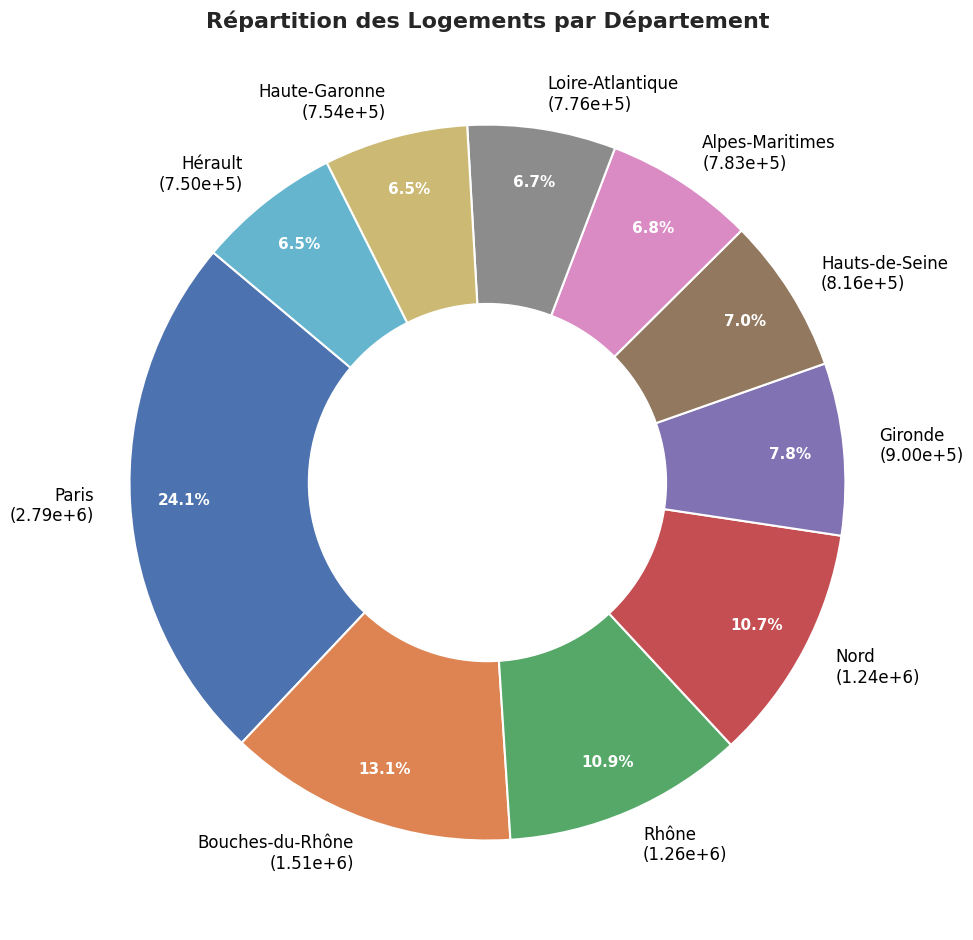

In [383]:
plt.figure(figsize=(10, 10))
wedges, texts, autotexts = plt.pie(
    res["TotalLogements"], 
    labels=res["nomDepartement"]+ "\n(" + res["TotalLogements"].apply(lambda x: f"{x:.2e}") + ")", 
    autopct='%1.1f%%', 
    startangle=140,
    pctdistance=0.85,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1.5}
)

for text in texts:
    text.set_fontsize(12)
    text.set_color("black")
for autotext in autotexts:
    autotext.set_fontsize(11)
    autotext.set_color("white")
    autotext.set_weight("bold")

centre_circle = plt.Circle((0, 0), 0.50, fc='white')
plt.gca().add_artist(centre_circle)

plt.title("Répartition des Logements par Département", fontsize=16, weight="bold")

plt.tight_layout()

plt.show()